In [1]:
camposE=[10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]
potenciales=[0.5,3,4,5,6,6.5,7,7.5,8,9,10,11,13,20]

In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
plt.style.use('seaborn-darkgrid')
matplotlib.rcParams.update({'font.size': 20})
from matplotlib import cm
cmap = cm.get_cmap('tab10', 10)




# Funcion que simplemente genera las palabras que queremos eliminar del archivo de la evolucion temporal
def palabrasEliminar(number_sim_=10):
    aux_list_ = ['------------------------------------------------------------\n','Time (ps), Velocity (m/s)\n',' Velocity Vs Time\n']
    for i in range(2,number_sim_+1):
        aux_str=' Velocity Vs Time (#'+str(i)+')\n'
        aux_list_.append(aux_str)
    return aux_list_

#Funcion que genera un archivo sin las pabras que molestan
def borraLineasTextoNumpyData(input_file_, aux_list_=palabrasEliminar()):
    with open(input_file_, 'r') as file_in:
        with open('aux_file.txt', 'w') as file_out:
            for line in file_in.readlines():
                if line not in aux_list_:
                    line_replace=line.replace(',', '')
                    file_out.write(line_replace)
    data_clean_=np.loadtxt('aux_file.txt')
    return data_clean_                    

#Como tenemos todo en el mismo arraym, convendria separar por Campos electricos las simulaciones
def separaSimulaciones(data_clean_,camposE_=[10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]):
    
    lista_con_todos=[]
    for number in enumerate(camposE_):
        aux_=[number[1], data_clean_[int((number[0])*data_clean_.shape[0]/len(camposE_)):int((number[0]+1)*data_clean_.shape[0]/len(camposE_)),0],data_clean_[int((number[0])*data_clean_.shape[0]/len(camposE_)):int((number[0]+1)*data_clean_.shape[0]/len(camposE_)),1]]
        lista_con_todos.append(aux_)
    return lista_con_todos #devuelve una lista de longitud = numero de simulaciones = numero de campos electricos, con la ev temporal 

# Genera Lo que nos da ya el progarama en VelocityvsElectricfield, pero con errores y varianza 
def generaTablaEvsMeanVel(lista_con_todos_):
    EvsV = []
    for element in lista_con_todos_:
        aux_good_range = element[2][int(0.2*element[2].shape[0]):int(0.8*element[2].shape[0])]
        aux_mean = aux_good_range.mean()
        aux_sigma = np.sqrt(aux_good_range.var())
        aux_rel = aux_sigma/aux_mean
        EvsV.append([element[0], aux_mean, aux_sigma, aux_rel])
    return EvsV

def hazTodoDadoelPotencial(file_Velvstime,debugprint=False,camposE=[10000,20000,30000,40000,50000,60000,70000,80000,90000,100000],pot='Unknown'):
    data_clean = borraLineasTextoNumpyData(file_Velvstime)
    todos = separaSimulaciones(data_clean,camposE)
    if debugprint==True:
        fig,ax = plt.subplots(1,1)
        fig.suptitle('Potencial: ' + pot)
        for element in todos:
            ax.plot(element[1],element[2])
            #ax.legend()
        plt.show()
    EvsMeanV = np.array(generaTablaEvsMeanVel(todos))
    if debugprint==True:
        fig2,axs = plt.subplots(1,1)
        axs.errorbar(EvsMeanV[:,0],EvsMeanV[:,1], EvsMeanV[:,2])
        axs.set_xlabel('Electric Field (V/m)')
        axs.set_xlabel('Mean Velocity(m/s)')
        #axs[1].plot(EvsMeanV[:,0],EvsMeanV[:,-1])
        #axs[1].set_xlabel('Electric Field (V/m)')
        #axs[1].set_ylabel('Relative Fluctuations (Mean/sigma)')
        
        plt.show()
    return EvsMeanV   

def ajusteLinealMovilidad(EvsVmean_, pot='Unknown', debug_printing_=False,pot_='Unknown'):
    x,y,erry =   EvsVmean_[:,0], EvsVmean_[:,1], EvsVmean_[:,2]
    ajuste = np.polyfit(x,y, 1, cov=True, full = False)
    movility, ordenada = ajuste[0]
    errores_ajuste = ajuste[1]
    corr_ajuste = np.corrcoef(x,y)
    
    if debug_printing_:
        modelo =  lambda x: movility*x + ordenada
        xvals = np.linspace(EvsVmean_[0][0],EvsVmean_[-1][0])
        fig,ax=plt.subplots(1,1)
        fig.suptitle('Potencial: ' + str(pot_))
        ax.errorbar(x,y , erry)
        ax.plot(xvals, modelo(xvals), label='Ajuste')
        ax.set_xlabel('Campo Electrico (V/m)')
        ax.set_ylabel('Velocidad media (m/s)')
    #print('Cojones: ', corr_ajuste)
    return movility, ordenada, errores_ajuste, corr_ajuste

def movilidadPotencial(file_VvsTime,pot_='Unknown'):
    datos_generales = hazTodoDadoelPotencial(file_VvsTime)
    movilidad = ajusteLinealMovilidad(datos_generales,pot_=pot_)
    return movilidad

#Funcion que devuelve lo que queremos estudiar en esta practica: movilidad vs pot. deformacion acustico. Para que funcione 
# los txt deben de tener el formato : Time#NumeroPotencial.txt, y se itera sobre eso. 
def movVsPot(potenciales=[0.5,3,4,5,6,6.5,7,7.5,8,9,10,11,13,20]):
    pot_Mov = []
    for pot in potenciales:
        mov = movilidadPotencial('Time'+str(pot)+'.txt',pot_=pot)
        pot_Mov.append([pot, mov[0], mov[2][0][0], mov]) # Potencial, movilidad, error movilidad, que es lo esencial, y en el ultimo aray todo junto por si se quiere echar mano
    return np.array(pot_Mov, dtype=object)

def ajustesMovDef(movVsPot_):
    potenciales, movilidades, errmov = movVsPot_[:,0].astype('float64'), movVsPot_[:,1].astype('float64'), np.sqrt(movVsPot_[:,2].astype('float64'))
    ajuste_lineal = np.polyfit(potenciales,movilidades, 1, cov=True, full = False)
    ajuste_cuadratico = np.polyfit(potenciales,movilidades, 2, cov=True, full = False)
    ajuste_teorico = np.polyfit(1/(potenciales**2),movilidades, 1, cov=True, full = False)
    lineal = lambda x: ajuste_lineal[0][0]*x+ajuste_lineal[0][1]
    cuad = lambda x: ajuste_cuadratico[0][0]*x*x+ajuste_cuadratico[0][1]*x+ajuste_cuadratico[0][2]
    teorico = lambda x: ajuste_teorico[0][0]/(x*x) 
    xvals = np.linspace(float(potenciales[0]),float(potenciales[-1]))
    
    fig, ax = plt.subplots(1,1)
    ax.errorbar(potenciales, movilidades, errmov)
    ax.plot(xvals, lineal(xvals),label='Lineal')
    ax.plot(xvals, cuad(xvals))
    ax.plot(xvals, teorico(xvals))
    plt.show()
    
    return ajuste_lineal, ajuste_cuadratico,ajuste_teorico

# Comprobamos que todo va bien

Dbe salir la evolución temporal para todos los campos, y un ajuste lineal de la movilidad. Esto es solo para ver que se ha hecho todo bien

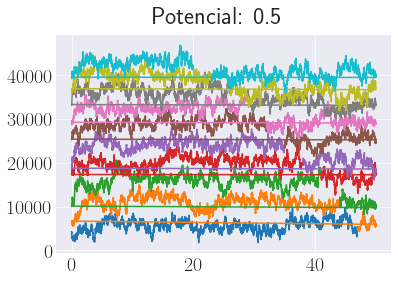

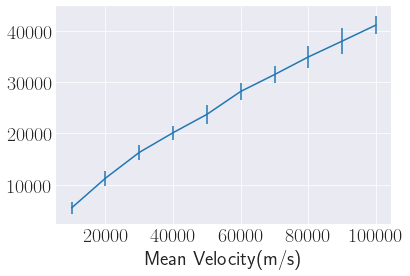

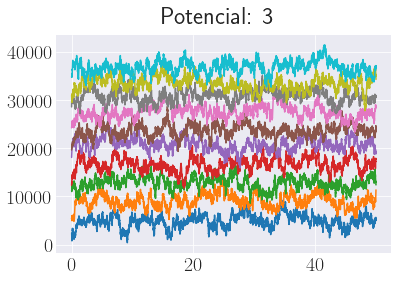

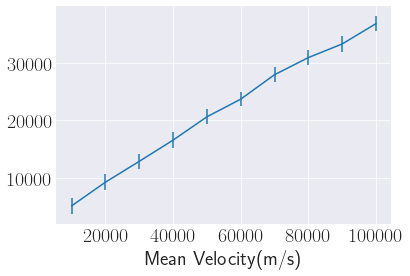

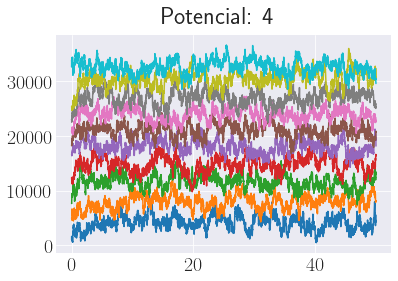

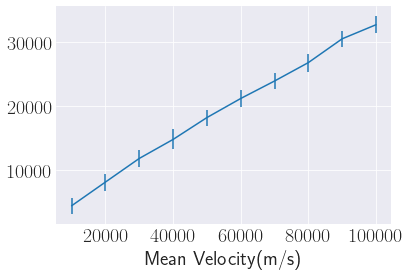

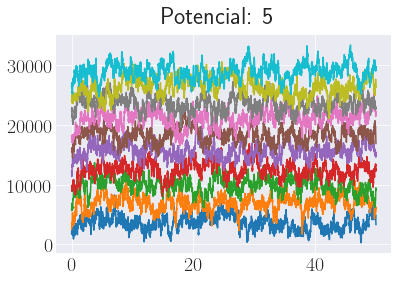

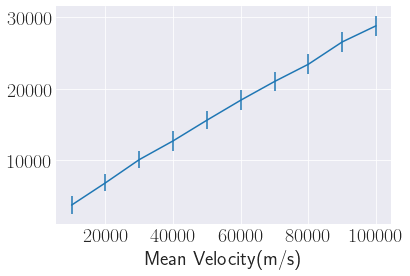

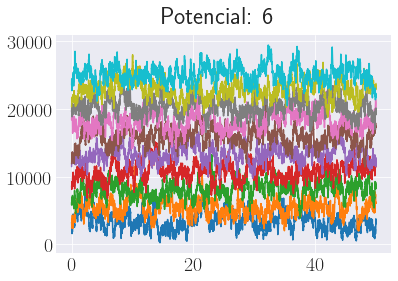

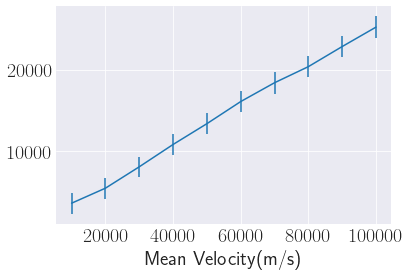

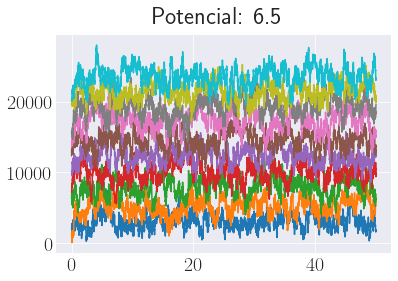

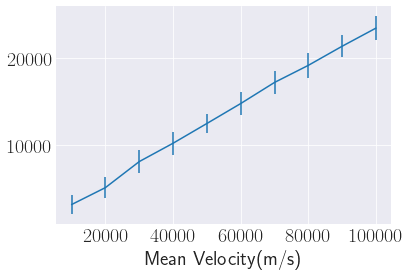

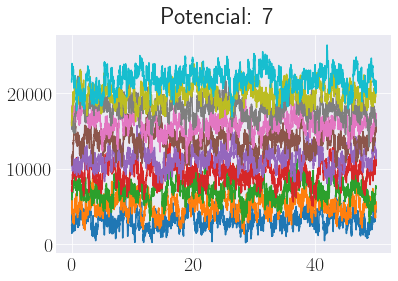

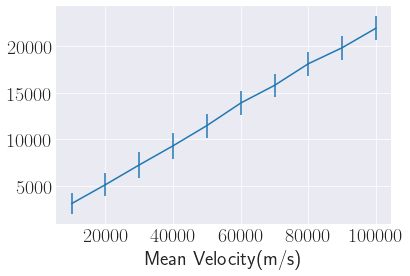

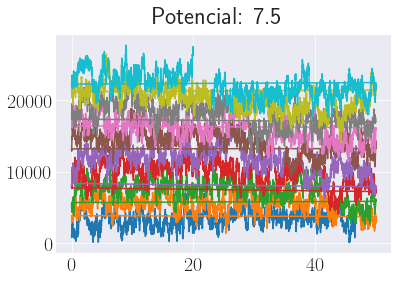

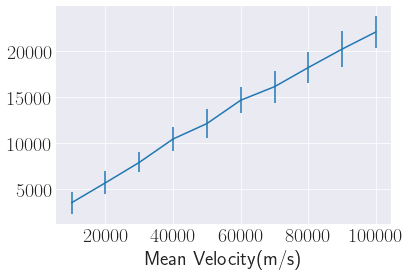

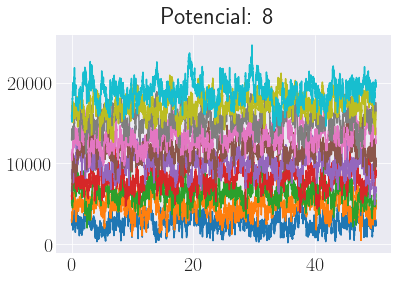

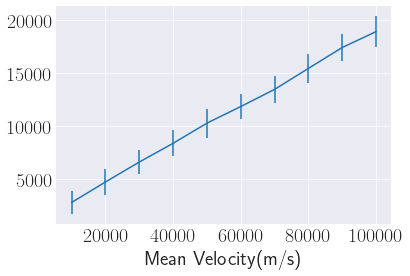

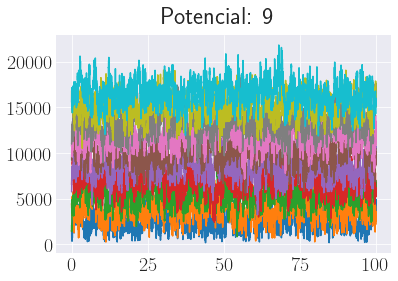

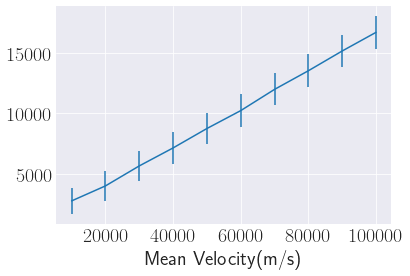

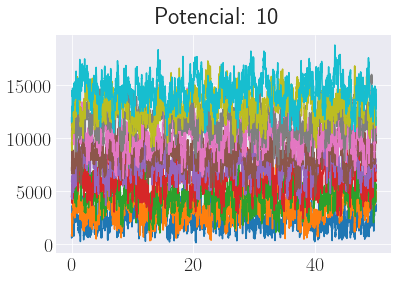

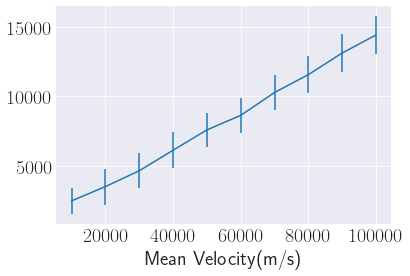

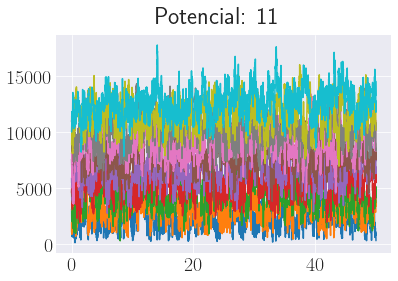

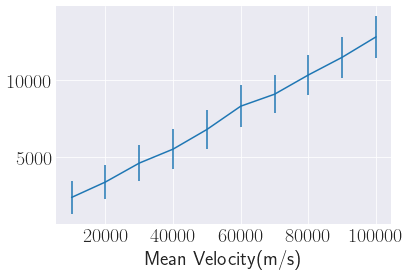

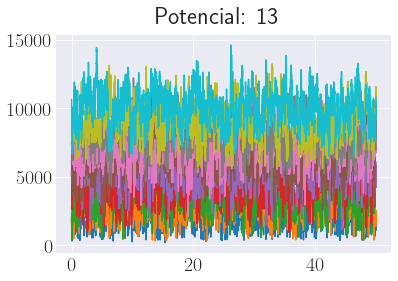

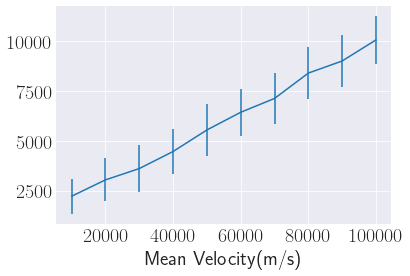

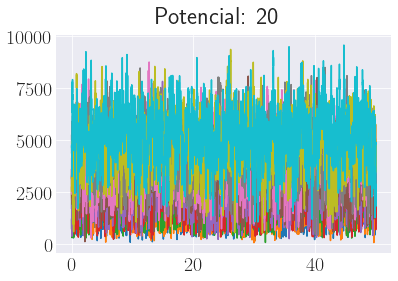

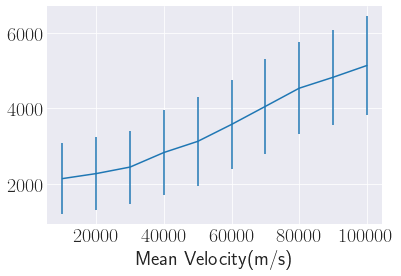

In [18]:
for potencial in potenciales:
    hazTodoDadoelPotencial('Time'+str(potencial)+'.txt',debugprint=True,pot=str(potencial))    

Se pueden usar las distintas funciones para obtener lo que queramos